# Detecting adversarial examples
This notebook implements four different adversarial detection methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

## Preparing data
* Preparing original dataset
* Downloading clean and adversarial images from the previous step. Splitting them into train and test subsets.

In [2]:
X_clean = torch.load('data/clean_examples.pt')
X_fgsm = torch.load('data/FGSM_examples.pt')
X_bim = torch.load('data/BIM_examples.pt')
X_deepfool = torch.load('data/DeepFool_examples.pt')
X_cw = torch.load('data/CW_examples.pt')

In [3]:
dataset_tar_path = './CINIC-10.tar.gz'
dataset_root = './cinic_root'
dataset_name = 'CINIC-10'

In [4]:
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

In [5]:
cinic_inv_mean = [-0.47889522, -0.47227842, -0.43047404]
cinic_inv_std = [1.0/0.24205776, 1.0/0.23828046, 1.0/0.25874835]

In [6]:
import tarfile

dataset_tar = tarfile.open(dataset_tar_path)
dataset_tar.extractall(dataset_root)
dataset_tar.close()


KeyboardInterrupt



In [6]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cinic_mean,std=cinic_std)])
# for showing images that will be crafted later
tf_denorm = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std=cinic_inv_std), \
                               transforms.Normalize(mean=cinic_inv_mean, std=[1., 1., 1.])])
tf_norm = transforms.Normalize(mean=cinic_mean,std=cinic_std)

In [7]:
train_data = ImageFolder(dataset_root + '/train', transform=tf)
valid_data = ImageFolder(dataset_root + '/valid', transform=tf)
test_data = ImageFolder(dataset_root + '/test', transform=tf)

In [8]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

## Preparing target model

In [52]:
'''
  ResNet18 from a popular repository
  url:https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
  Modification:
  * a dropout layer for randomization
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
'''

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # dropout for mc-uncertainty
        self.dr = nn.Dropout(0.5)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.dr(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def get_hidden_output(self, x, layer_idx):
        out = F.relu(self.bn1(self.conv1(x)))
        if layer_idx == 0:
            return out
        out = self.layer1(out)
        if layer_idx == 1:
            return out
        out = self.layer2(out)
        if layer_idx == 2:
            return out
        out = self.layer3(out)
        if layer_idx == 3:
            return out
        out = self.layer4(out)
        if layer_idx == 4:
            return out
        out = F.avg_pool2d(out, 4)
        if layer_idx == 5 or layer_idx == -1:
            return out
        out = self.dr(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)
model.load_state_dict(torch.load('resnet18_cinic_fin.pth'))

<All keys matched successfully>

In [33]:
!pip install torchsummary
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Preparing data and parameters for detection
* Labeling data
* Splitting data into train and test subsets
* Tuning bandwidth (sigma) for KDE and k for LID
* Fetching training data from original dataset
* Adding functionality for saving features

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

In [55]:
#labeling data
def label_data(model, data):
    labels = torch.zeros(len(data))
    model.eval()
    for i in range(100):
        data_batch = data[i * 100:(i + 1) * 100].to(device)
        with torch.no_grad():
            outputs = model(data_batch).cpu()
        labels[i * 100:(i + 1) * 100] = torch.argmax(outputs, 1)
    
    return labels

In [56]:
y_clean = label_data(model, X_clean)
y_fgsm = label_data(model, X_fgsm)
y_bim = label_data(model, X_bim)
y_deepfool = label_data(model, X_deepfool)
y_cw = label_data(model, X_cw)

In [57]:
def split_train_test(X, y):
    return X[:8000], X[8000:], y[:8000], y[8000:]

In [58]:
# splitting data
X_clean_train, X_clean_test, y_clean_train, y_clean_test = split_train_test(X_clean, y_clean)
X_fgsm_train, X_fgsm_test, y_fgsm_train, y_fgsm_test = split_train_test(X_fgsm, y_fgsm)
X_bim_train, X_bim_test, y_bim_train, y_bim_test = split_train_test(X_bim, y_bim)
X_deepfool_train, X_deepfool_test, y_deepfool_train, y_deepfool_test = split_train_test(X_deepfool, y_deepfool)
X_cw_train, X_cw_test, y_cw_train, y_cw_test = split_train_test(X_cw, y_cw)

In [ ]:
params = {'bandwidth': np.logspace(-1, 1, 50)}
grid = GridSearchCV(KernelDensity(), params, n_jobs=-1)
grid.fit(X_clean_train.reshape((8000,-1)).detach().numpy())

sigma = grid.best_estimator_.bandwidth

In [47]:
params = {'n_clusters': np.arange(10, 100)}
grid = GridSearchCV(KMeans(), params, n_jobs=-1)
grid.fit(X_clean_train.reshape((8000, -1)).detach().numpy())

k = grid.best_estimator_.n_clusters

In [45]:
def save_features(features, split_name, set_name, feature_name):
    dirname = './' + feature_name + '/'
    filename = feature_name + '_' + set_name + '_' + split_name
    path = dirname + filename
    torch.save(features, path)

In [17]:
X_train = torch.empty((0, 3, 32, 32))
y_train = torch.empty(0)

for X, y in train_loader:
    X_train = torch.cat((X_train, X))
    y_train = torch.cat((y_train, y))

In [59]:
# listing rounded values of tuned parameters
sigma = 0.55
k = 91

## Detector interface

In [46]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve, roc_auc_score

In [47]:
def form_detection_data(features_neg, features_pos):
    values_neg = features_neg.reshape(1, -1).transpose(1, 0)
    values_pos = features_pos.reshape(1, -1).transpose(1, 0)
    
    values = torch.cat((values_neg, values_pos))
    labels = torch.cat((torch.zeros_like(features_neg), torch.ones_like(features_pos)))
    
    return values, labels

In [48]:
def train_detector(values, labels):
    
    lr = LogisticRegressionCV(n_jobs=-1).fit(values,labels)
    
    return lr

In [49]:
def compute_roc(y_true, y_pred, plot=False):
    """
    TODO
    :param y_true: ground truth
    :param y_pred: predictions
    :param plot:
    :return:
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score

## Kernel Density Estimation

In [63]:
k = torch.zeros((1, 3, 32, 32)).to(device)
out_deep = model.get_hidden_output(k, -1)
last_hidden_dim = out_deep.squeeze(0).shape

In [73]:
last_hidden_dim

torch.Size([512, 1, 1])

In [86]:
def get_deep_representations(model, X, device, batch_size=256):
    model.eval()

    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    output = torch.zeros((len(X), 512, 1, 1))
    for i in tqdm(range(n_batches)):
        X_batch = X[i * batch_size:(i + 1) * batch_size].to(device)
        with torch.no_grad():
            output[i * batch_size:(i + 1) * batch_size] = model.get_hidden_output(X_batch, -1).cpu()
    return output

In [87]:
X_train_df = get_deep_representations(model, X_train, device)

100%|██████████| 352/352 [00:03<00:00, 102.84it/s]


In [88]:
X_train_df = X_train_df.reshape((len(X_train_df), -1))

In [89]:
class_indices = {}
kdes = {}

for i in range(10):
    class_indices[i] = np.where(y_train == i)

for i in range(10):
    kdes[i] = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(X_train_df[class_indices[i]].cpu().detach().numpy())

In [90]:
def score_densities(features, labels, kdes):
    densities = torch.empty(0)
    for i in range(labels.shape[0]):
        class_label = labels[i].item()
        densities = torch.cat((densities, torch.from_numpy(kdes[class_label].score_samples(features[i].reshape((1, -1)).cpu().detach().numpy()))))
    return densities

In [91]:
X_clean_train_df = get_deep_representations(model, X_clean_train, device).reshape((len(X_clean_train), -1))
X_clean_test_df = get_deep_representations(model, X_clean_test, device).reshape((len(X_clean_test), -1))
X_fgsm_train_df = get_deep_representations(model, X_fgsm_train, device).reshape((len(X_clean_train), -1))
X_fgsm_test_df = get_deep_representations(model, X_fgsm_test, device).reshape((len(X_clean_test), -1))
X_bim_train_df = get_deep_representations(model, X_bim_train, device).reshape((len(X_clean_train), -1))
X_bim_test_df = get_deep_representations(model, X_bim_test, device).reshape((len(X_clean_test), -1))
X_deepfool_train_df = get_deep_representations(model, X_deepfool_train, device).reshape((len(X_clean_train), -1))
X_deepfool_test_df = get_deep_representations(model, X_deepfool_test, device).reshape((len(X_clean_test), -1))
X_cw_train_df = get_deep_representations(model, X_cw_train, device).reshape((len(X_clean_train), -1))
X_cw_test_df = get_deep_representations(model, X_cw_test, device).reshape((len(X_clean_test), -1))

100%|██████████| 8/8 [00:00<00:00, 103.28it/s]


In [ ]:
densities_clean_train = score_densities(X_clean_train_df, y_clean_train, kdes)
densities_clean_test = score_densities(X_clean_test_df, y_clean_test, kdes)
densities_fgsm_train = score_densities(X_fgsm_train_df, y_fgsm_train, kdes)
densities_fgsm_test = score_densities(X_fgsm_test_df, y_fgsm_test, kdes)
densities_bim_train = score_densities(X_bim_train_df, y_bim_train, kdes)
densities_bim_test = score_densities(X_bim_test_df, y_bim_test, kdes)
densities_deepfool_train = score_densities(X_deepfool_train_df, y_deepfool_train, kdes)
densities_deepfool_test = score_densities(X_deepfool_test_df, y_deepfool_test, kdes)
densities_cw_train = score_densities(X_cw_train_df, y_cw_train, kdes)
densities_cw_test = score_densities(X_cw_test_df, y_cw_test, kdes)

In [ ]:
values_train_fgsm, labels_train_fgsm = form_detection_data(densities_clean_train, densities_fgsm_train)
values_test_fgsm, labels_test_fgsm = form_detection_data(densities_clean_test, densities_fgsm_test)
detector_fgsm_kde = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_kde.predict_proba(values_test_fgsm)[:, 1])
_, _, auc_score = compute_roc(labels_test_fgsm, probs, plot=True)

In [ ]:
values_train_bim, labels_train_bim = form_detection_data(densities_clean_train, densities_bim_train)
values_test_bim, labels_test_bim = form_detection_data(densities_clean_test, densities_bim_test)
detector_bim_kde = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_kde.predict_proba(values_test_bim)[:, 1])
_, _, auc_score = compute_roc(labels_test_bim, probs, plot=True)

In [ ]:
values_train_deepfool, labels_train_deepfool = form_detection_data(densities_clean_train, densities_deepfool_train)
values_test_deepfool, labels_test_deepfool = form_detection_data(densities_clean_test, densities_deepfool_test)
detector_deepfool_kde = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_kde.predict_proba(values_test_deepfool)[:, 1])
_, _, auc_score = compute_roc(labels_test_deepfool, probs, plot=True)

In [ ]:
values_train_cw, labels_train_cw = form_detection_data(densities_clean_train, densities_cw_train)
values_test_cw, labels_test_cw = form_detection_data(densities_clean_test, densities_cw_test)
detector_cw_kde = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_kde.predict_proba(values_test_cw)[:, 1])
_, _, auc_score = compute_roc(labels_test_cw, probs, plot=True)

## Bayesian uncertainty

In [103]:
def get_mc_predictions(model, images, batch_size=256, num_iter=50):
    output_dim = 10

    model.train()

    def predict():
        num_batches = int(np.ceil(images.shape[0] / float(batch_size)))
        output = torch.zeros(size=(images.shape[0], output_dim))
        with torch.no_grad():
            for i in range(num_batches):
                images_batch = images[i * batch_size:(i + 1) * batch_size].to(device)
                output[i * batch_size:(i + 1) * batch_size] = F.softmax(model(images_batch), dim=1)

        return output

    predictions_mc = torch.empty(0, images.shape[0], output_dim)

    for i in range(num_iter):
        predictions_mc = torch.cat((predictions_mc, predict().unsqueeze(0)))

    return predictions_mc

In [170]:
uncerts_clean_train = get_mc_predictions(model, X_clean_train).var(dim=0).mean(dim=1)
uncerts_clean_test = get_mc_predictions(model, X_clean_test).var(dim=0).mean(dim=1)
uncerts_fgsm_train = get_mc_predictions(model, X_fgsm_train).var(dim=0).mean(dim=1)
uncerts_fgsm_test = get_mc_predictions(model, X_fgsm_test).var(dim=0).mean(dim=1)
uncerts_bim_train = get_mc_predictions(model, X_bim_train).var(dim=0).mean(dim=1)
uncerts_bim_test = get_mc_predictions(model, X_bim_test).var(dim=0).mean(dim=1)
uncerts_deepfool_train = get_mc_predictions(model, X_deepfool_train).var(dim=0).mean(dim=1)
uncerts_deepfool_test = get_mc_predictions(model, X_deepfool_test).var(dim=0).mean(dim=1)
uncerts_cw_train = get_mc_predictions(model, X_cw_train).var(dim=0).mean(dim=1)
uncerts_cw_test = get_mc_predictions(model, X_cw_test).var(dim=0).mean(dim=1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt




KeyboardInterrupt



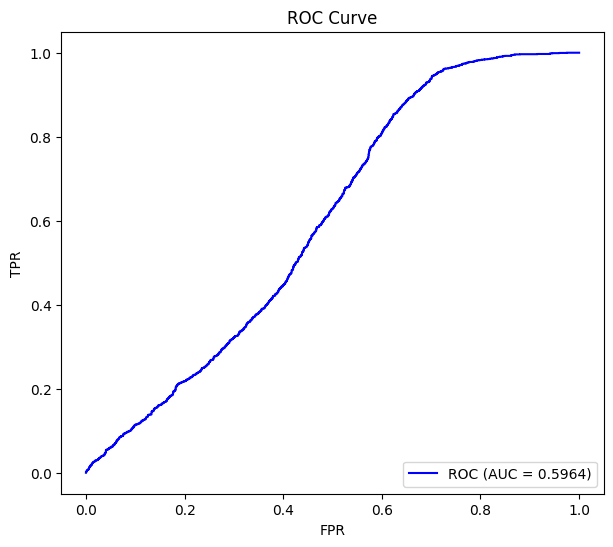

In [169]:
values_train_fgsm, labels_train_fgsm = form_detection_data(uncerts_clean_train, uncerts_fgsm_train)
values_test_fgsm, labels_test_fgsm = form_detection_data(uncerts_clean_test, uncerts_fgsm_test)
detector_fgsm_bu = train_detector(values_train_fgsm.numpy(), labels_train_fgsm.numpy())
probs = torch.tensor(detector_bim_bu.predict_proba(values_test_bim.numpy())[:, 1])
_, _, auc_score = compute_roc(labels_test_fgsm.numpy(), probs.numpy(), plot=True)

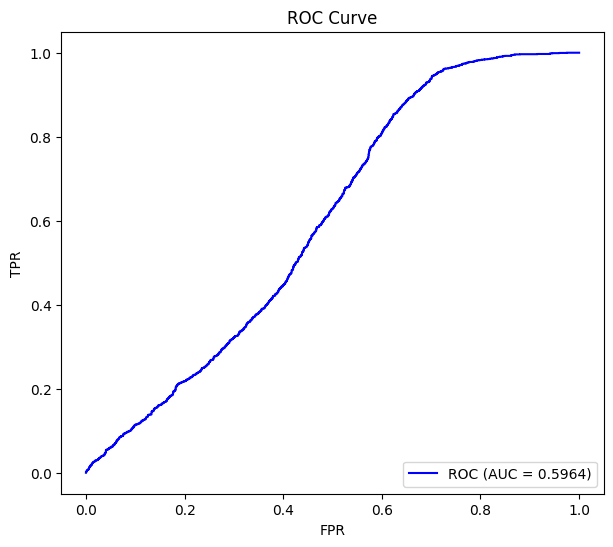

In [168]:
values_train_bim, labels_train_bim = form_detection_data(uncerts_clean_train, uncerts_bim_train)
values_test_bim, labels_test_bim = form_detection_data(uncerts_clean_test, uncerts_bim_test)
detector_bim_bu = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_bu.predict_proba(values_test_bim)[:, 1])
_, _, auc_score = compute_roc(labels_test_bim, probs, plot=True)

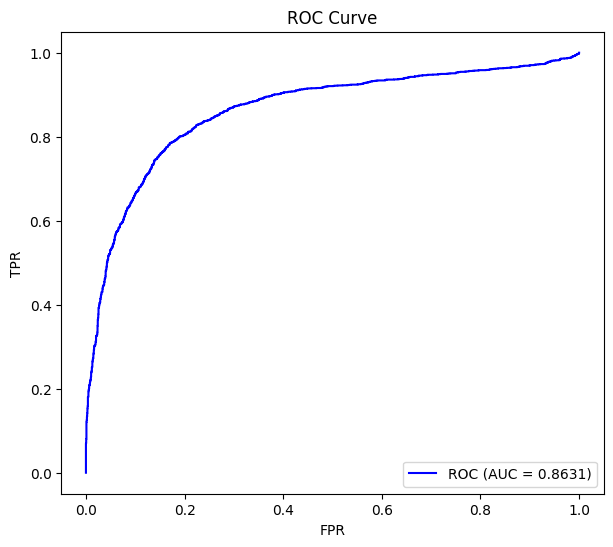

In [107]:
values_train_deepfool, labels_train_deepfool = form_detection_data(uncerts_clean_train, uncerts_deepfool_train)
values_test_deepfool, labels_test_deepfool = form_detection_data(uncerts_clean_test, uncerts_deepfool_test)
detector_deepfool_bu = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_bu.predict_proba(values_test_deepfool)[:, 1])
_, _, auc_score = compute_roc(labels_test_deepfool, probs, plot=True)

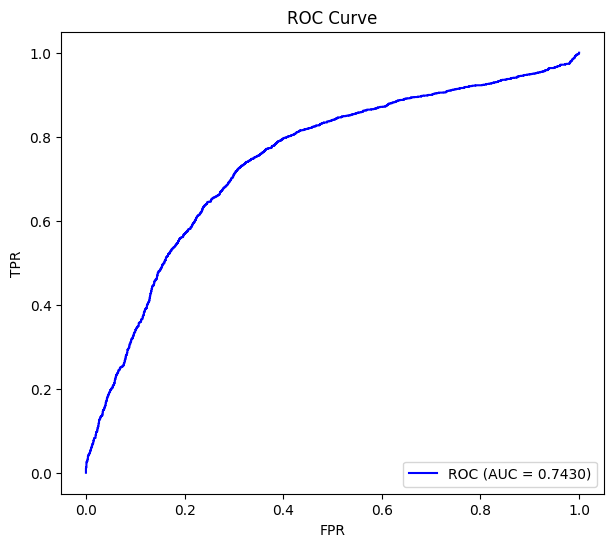

In [108]:
values_train_cw, labels_train_cw = form_detection_data(uncerts_clean_train, uncerts_cw_train)
values_test_cw, labels_test_cw = form_detection_data(uncerts_clean_test, uncerts_cw_test)
detector_cw_bu = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_bu.predict_proba(values_test_cw)[:, 1])
_, _, auc_score = compute_roc(labels_test_cw, probs, plot=True)

In [ ]:
np.save()

## Local intrinsic dimensionality

In [64]:
from scipy.spatial.distance import cdist

In [65]:
def get_softmax_batch(model, X):
    with torch.no_grad():
        output = F.softmax(model(X.to(device)), 1)
    return output

In [66]:
def mle_batch(data, batch, k):
    data = torch.asarray(data, dtype=torch.float32).cpu()
    batch = torch.asarray(batch, dtype=torch.float32).cpu()

    k = min(k, len(data)-1)
    f = lambda v: - k / np.sum(np.log(v/v[-1]))
    
    a = cdist(batch, data)
    a = np.apply_along_axis(np.sort, axis=1, arr=a)[:,1:k+1]
    a = np.apply_along_axis(f, axis=1, arr=a)
    return torch.from_numpy(a)

In [67]:
def get_lids_batch(model, X_clean, X_dest, k):
    lids_batch = torch.zeros(len(X_clean))
    
    X_softmax = get_softmax_batch(model, X_clean)
    
    X_softmax_dest = get_softmax_batch(model, X_dest)
    
    lids_batch = mle_batch(X_softmax, X_softmax_dest, k=k)
    
    return lids_batch

In [74]:
def get_lids(model, X_clean, X_fgsm, X_bim, X_deepfool, X_cw, k, batch_size=100):
    lids_clean = torch.zeros(len(X_clean))
    lids_fgsm = torch.zeros(len(X_clean))
    lids_bim = torch.zeros(len(X_clean))
    lids_deepfool = torch.zeros(len(X_clean))
    lids_cw = torch.zeros(len(X_clean))
    
    n_batches = int(np.ceil(X_clean.shape[0] / float(batch_size)))
    for i in tqdm(range(n_batches)):
        start = i * batch_size
        end = np.minimum(len(X_clean), (i + 1) * batch_size)
        lids_batch_clean = get_lids_batch(model, X_clean[start:end], X_clean[start:end], k)
        lids_clean[start:end] = lids_batch_clean
        
        lids_batch_fgsm = get_lids_batch(model, X_clean[start:end], X_fgsm[start:end], k)
        lids_fgsm[start:end] = lids_batch_fgsm
        
        lids_batch_bim = get_lids_batch(model, X_clean[start:end], X_bim[start:end], k)
        lids_bim[start:end] = lids_batch_bim
        
        lids_batch_deepfool = get_lids_batch(model, X_clean[start:end], X_deepfool[start:end], k)
        lids_deepfool[start:end] = lids_batch_deepfool
        
        lids_batch_cw = get_lids_batch(model, X_clean[start:end], X_cw[start:end], k)
        lids_cw[start:end] = lids_batch_cw

    return lids_clean, lids_fgsm, lids_bim, lids_deepfool, lids_cw

In [75]:
lids_clean_train, lids_fgsm_train, lids_bim_train, lids_deepfool_train, lids_cw_train = \
    get_lids(model, X_clean_train, X_fgsm_train, X_bim_train, X_deepfool_train, X_cw_train, k)
lids_clean_test, lids_fgsm_test, lids_bim_test, lids_deepfool_test, lids_cw_test = \
    get_lids(model, X_clean_test, X_fgsm_test, X_bim_test, X_deepfool_test, X_cw_test, k)

100%|██████████| 20/20 [00:00<00:00, 24.87it/s]


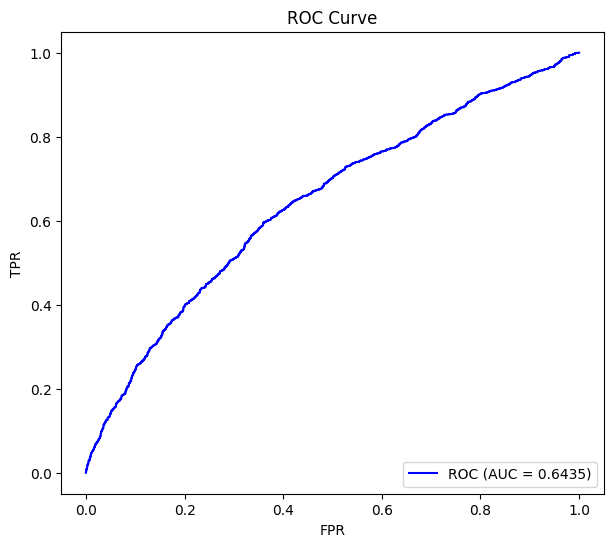

In [76]:
values_train_fgsm, labels_train_fgsm = form_detection_data(lids_clean_train, lids_fgsm_train)
values_test_fgsm, labels_test_fgsm = form_detection_data(lids_clean_test, lids_fgsm_test)
detector_fgsm_lid = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_lid.predict_proba(values_test_fgsm)[:, 1])
_, _, auc_score = compute_roc(labels_test_fgsm, probs, plot=True)

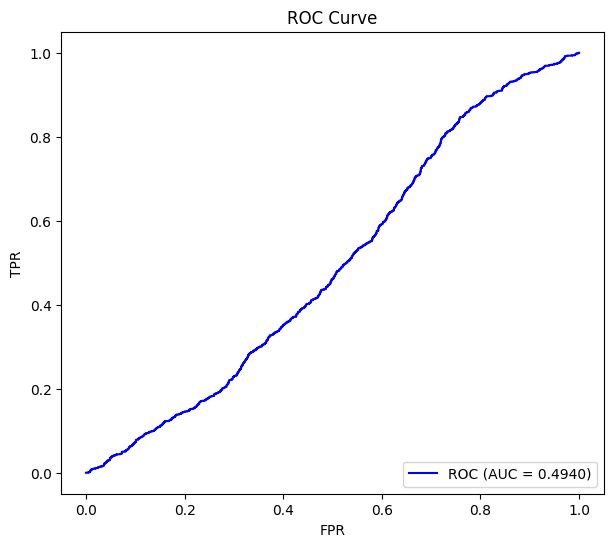

In [134]:
values_train_bim, labels_train_bim = form_detection_data(lids_clean_train, lids_bim_train)
values_test_bim, labels_test_bim = form_detection_data(lids_clean_test, lids_bim_test)
detector_bim_lid = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_lid.predict_proba(values_test_bim)[:, 1])
_, _, auc_score = compute_roc(labels_test_bim, probs, plot=True)

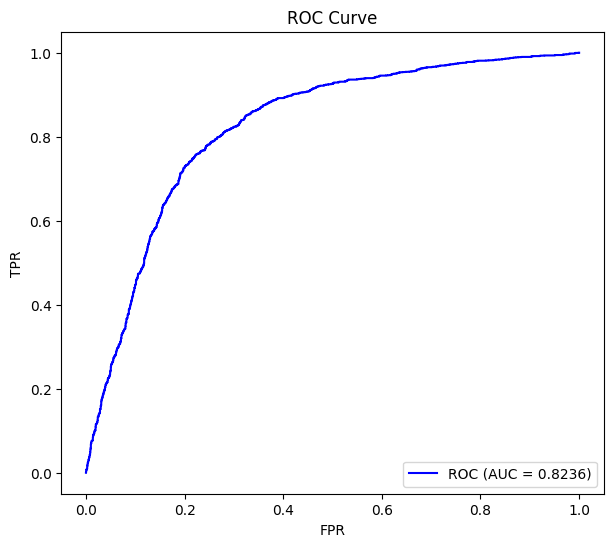

In [80]:
values_train_deepfool, labels_train_deepfool = form_detection_data(lids_clean_train, lids_deepfool_train)
values_test_deepfool, labels_test_deepfool = form_detection_data(lids_clean_test, lids_deepfool_test)
detector_deepfool_lid = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_lid.predict_proba(values_test_deepfool)[:, 1])
_, _, auc_score = compute_roc(labels_test_deepfool, probs, plot=True)

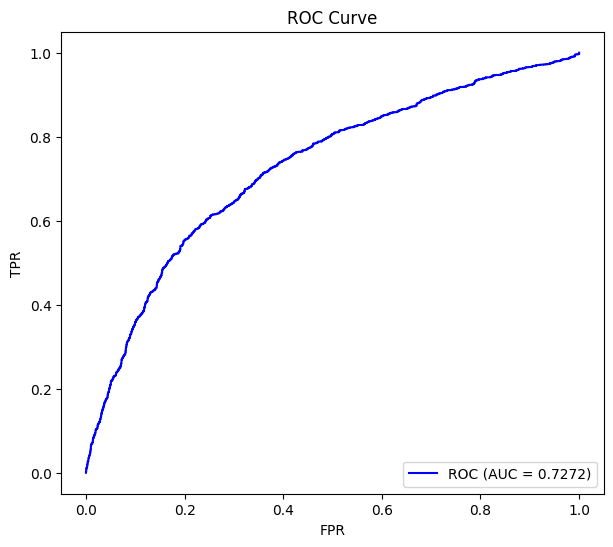

In [133]:
values_train_cw, labels_train_cw = form_detection_data(lids_clean_train, lids_cw_train)
values_test_cw, labels_test_cw = form_detection_data(lids_clean_test, lids_cw_test)
detector_cw_lid = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_lid.predict_proba(values_test_cw)[:, 1])
_, _, auc_score = compute_roc(labels_test_cw, probs, plot=True)

## Mahalanobis distance

In [132]:
layer_list = list(model.modules())
layer_indices = []

for i in range(1, len(layer_list)):
    if isinstance(layer_list[i], nn.modules.conv.Conv2d) or \
       isinstance(layer_list[i], nn.modules.linear.Linear) or \
       isinstance(layer_list[i], nn.modules.batchnorm.BatchNorm2d):
        layer_indices.append(i)

In [192]:
def get_layer_output_batch(model, X):
    hook_handlers = []
    outputs = []
    
    def layer_hook(module, input_, output):
        outputs.append(output)
    
    for layer in model.modules():
        if isinstance(layer, nn.modules.conv.Conv2D) or \
           isinstance(layer, nn.modules.linear.Linear) or \
           isinstance(layer, nn.modules.batchnorm.BatchNorm2d):
            handle = layer.register_forward_hook(layer_hook)
            hook_handlers.append(handle)
    
    _ = model(X)
    
    return outputs            

In [17]:
def get_layer_outputs_batch(model, X):
    hook_handlers = []
    outputs = []
    
    def layer_hook(module, input_, output):
        outputs.append(output)
    
    for layer in model.modules():
        if isinstance(layer, nn.modules.conc.Conv2D) or \
           isinstance(layer, nn.modules.linear.Linear) or \
           isinstance(layer, nn.modules.batchnorm.BatchNorm2d):
            handle = layer.register_forward_hook(layer_hook)
            hook_handlers.append(handle)
    
    _ = model(X)
    
    return outputs            

In [165]:
def get_Mahalanobis_score_adv(model, test_data, test_label, num_classes, sample_mean, precision, layer_index, magnitude=0.0):
    '''
    Compute the proposed Mahalanobis confidence score on adversarial samples
    return: Mahalanobis score from layer_index
    '''
    model.eval()
    Mahalanobis = []
    batch_size = 100
    total = 0
    
    for data_index in range(int(np.floor(test_data.size(0)/batch_size))):
        target = test_label[total : total + batch_size].cuda()
        data = test_data[total : total + batch_size].cuda()
        total += batch_size
        data, target = Variable(data, requires_grad = True), Variable(target)
        
        out_features = model.get_hidden_output(data, layer_index)
        out_features = out_features.view(out_features.size(0), out_features.size(1), -1)
        out_features = torch.mean(out_features, 2)
        
        gaussian_score = 0
        for i in range(num_classes):
            batch_sample_mean = sample_mean[layer_index][i]
            zero_f = out_features.data - batch_sample_mean
            term_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
            if i == 0:
                gaussian_score = term_gau.view(-1,1)
            else:
                gaussian_score = torch.cat((gaussian_score, term_gau.view(-1,1)), 1)
        
        # Input_processing
        sample_pred = gaussian_score.max(1)[1]
        batch_sample_mean = sample_mean[layer_index].index_select(0, sample_pred)
        zero_f = out_features - Variable(batch_sample_mean)
        pure_gau = -0.5*torch.mm(torch.mm(zero_f, Variable(precision[layer_index])), zero_f.t()).diag()
        loss = torch.mean(-pure_gau)
        loss.backward()
            
        gradient =  torch.ge(data.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        if net_type == 'densenet':
            gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (63.0/255.0))
            gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (62.1/255.0))
            gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (66.7/255.0))
        elif net_type == 'resnet':
            gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (0.2023))
            gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (0.1994))
            gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (0.2010))
        tempInputs = torch.add(data.data, -magnitude, gradient)
    
        noise_out_features = model.get_hidden_output(Variable(tempInputs, volatile=True), layer_index)
        noise_out_features = noise_out_features.view(noise_out_features.size(0), noise_out_features.size(1), -1)
        noise_out_features = torch.mean(noise_out_features, 2)
        noise_gaussian_score = 0
        for i in range(num_classes):
            batch_sample_mean = sample_mean[layer_index][i]
            zero_f = noise_out_features.data - batch_sample_mean
            term_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
            if i == 0:
                noise_gaussian_score = term_gau.view(-1,1)
            else:
                noise_gaussian_score = torch.cat((noise_gaussian_score, term_gau.view(-1,1)), 1)      

        noise_gaussian_score, _ = torch.max(noise_gaussian_score, dim=1)
        Mahalanobis.extend(noise_gaussian_score.cpu().numpy())
        
    return Mahalanobis

In [ ]:
def sample_estimator(model, num_classes, feature_list, train_loader):
    """
    compute sample mean and precision (inverse of covariance)
    return: sample_class_mean: list of class mean
             precision: list of precisions
    """
    import sklearn.covariance
    
    model.eval()
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    correct, total = 0, 0
    num_output = len(feature_list)
    num_sample_per_class = np.empty(num_classes)
    num_sample_per_class.fill(0)
    list_features = []
    for i in range(num_output):
        temp_list = []
        for j in range(num_classes):
            temp_list.append(0)
        list_features.append(temp_list)
    
    for data, target in train_loader:
        total += data.size(0)
        data = data.cuda()
        data = Variable(data, volatile=True)
        output, out_features = model.feature_list(data)
        
        # get hidden features
        for i in range(num_output):
            out_features[i] = out_features[i].view(out_features[i].size(0), out_features[i].size(1), -1)
            out_features[i] = torch.mean(out_features[i].data, 2)
            
        # compute the accuracy
        pred = output.data.max(1)[1]
        equal_flag = pred.eq(target.cuda()).cpu()
        correct += equal_flag.sum()
        
        # construct the sample matrix
        for i in range(data.size(0)):
            label = target[i]
            if num_sample_per_class[label] == 0:
                out_count = 0
                for out in out_features:
                    list_features[out_count][label] = out[i].view(1, -1)
                    out_count += 1
            else:
                out_count = 0
                for out in out_features:
                    list_features[out_count][label] \
                    = torch.cat((list_features[out_count][label], out[i].view(1, -1)), 0)
                    out_count += 1                
            num_sample_per_class[label] += 1
            
    sample_class_mean = []
    out_count = 0
    for num_feature in feature_list:
        temp_list = torch.Tensor(num_classes, int(num_feature)).cuda()
        for j in range(num_classes):
            temp_list[j] = torch.mean(list_features[out_count][j], 0)
        sample_class_mean.append(temp_list)
        out_count += 1
        
    precision = []
    for k in range(num_output):
        X = 0
        for i in range(num_classes):
            if i == 0:
                X = list_features[k][i] - sample_class_mean[k][i]
            else:
                X = torch.cat((X, list_features[k][i] - sample_class_mean[k][i]), 0)
                
        # find inverse            
        group_lasso.fit(X.cpu().numpy())
        temp_precision = group_lasso.precision_
        temp_precision = torch.from_numpy(temp_precision).float().cuda()
        precision.append(temp_precision)
        
    print('\n Training Accuracy:({:.2f}%)\n'.format(100. * correct / total))

    return sample_class_mean, precision

## Saving detectors for future research

In [ ]:
from sklearn.externals import joblib

In [ ]:
def save_detector(detector, method_name, attack_name):
    filename = method_name + '_' + attack_name '_' + 'detector.pkl'
    joblib.dump(detector, filename)

In [ ]:
def load_detector(method_name, attack_name):
    filename = f'{method_name}_{attack_name}_detector.pkl'
    return joblib.load(filename)

In [ ]:
save_detector(detector_fgsm_kde, 'kde', 'fgsm')
save_detector(detector_bim_kde, 'kde', 'bim')
save_detector(detector_deepfool_kde, 'kde', 'deepfool')
save_detector(detector_cw_kde, 'kde', 'cw')
save_detector(detector_fgsm_bu, 'bu', 'fgsm')
save_detector(detector_bim_bu, 'bu', 'bim')
save_detector(detector_deepfool_bu, 'bu', 'deepfool')
save_detector(detector_cw_bu, 'bu', 'cw')
save_detector(detector_fgsm_lid, 'lid', 'fgsm')
save_detector(detector_bim_lid, 'lid', 'bim')
save_detector(detector_deepfool_lid, 'lid', 'deepfool')
save_detector(detector_cw_lid, 'lid', 'cw')
#save_detector(detector_fgsm_md, 'md', 'fgsm')
#save_detector(detector_bim_md, 'md', 'bim')
#save_detector(detector_deepfool_md, 'md', 'deepfool')
#save_detector(detector_cw_md, 'md', 'cw')